In [1]:
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots
import repath.data.datasets.bloodmucus as bloodm

level = 7
dset = bloodm.training()

#thumbz, annotz = get_slides_annots(dset, level)


In [2]:
from PIL import Image
import numpy as np

def show_np(arr_in):
    return Image.fromarray(np.array(arr_in, dtype=np.uint8))

#show_np(annotz[0]*50)


In [3]:
from repath.experiments.bloodmuc import *

train_classifier()


KeyboardInterrupt: 

In [4]:
import json
from joblib import dump, load
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

import repath.data.datasets.bloodmucus as bloodm
from repath.preprocess.patching import GridPatchFinder, SlidesIndex, CombinedIndex
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots, apply_tissue_detection, get_features_list, fit_segmenter_multi, predict_segmenter, get_features, pool_blood_mucus
from repath.utils.paths import project_root
from repath.utils.seeds import set_seed

"""
Global stuff
"""
experiment_name = "bloodmucus"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123

In [ ]:
# # set values
# set_seed(global_seed)
# level_label = 6
thumb_level = 7

# # read in slides and annotations for training
dset = bloodm.blood_mucus()
# thumbz, annotz = get_slides_annots(dset, level_label)
thumbz_out, annotz_out = get_slides_annots(dset, thumb_level)

# ## temp for debugging
# thumbz = thumbz[20:]
# annotz = annotz[20:]
# thumbz_out = thumbz_out[20:]
# annotz_out = annotz_out[20:]

# # apply tissue detection
# morphology_transform1 = SizedClosingTransform(level_in=level_label)
# morphology_transform2 = FillHolesTransform(level_in=level_label)
# morphology_transforms = [morphology_transform1, morphology_transform2]
# tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
# filtered_thumbz = apply_tissue_detection(thumbz, tissue_detector)

# # get features
# featz = get_features_list(filtered_thumbz)

# # load classifier
# clf = load(experiment_root / 'rforest.joblib')

# # settings
# patch_level = 0
# patch_size = 2**thumb_level
# stride = patch_size
# scale_factor = 2 ** (level_label - patch_level)
# kernel_size = int(patch_size / scale_factor)
# label_level_stride = int(stride / scale_factor)

# # set output directories
# labels_dir = experiment_root / 'labels'
# labels_dir.mkdir(parents=True, exist_ok=True)
# tissue_dir = experiment_root / 'tissue'
# tissue_dir.mkdir(parents=True, exist_ok=True)
# bloodm_dir = experiment_root / 'bloodm'
# bloodm_dir.mkdir(parents=True, exist_ok=True)
# annot_out_dir = experiment_root / 'annot_out'
# annot_out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# for idx, thumb in enumerate(thumbz):
#     features = get_features(thumb)
#     output = predict_segmenter(features, clf)
#     tissue_mask = tissue_detector(thumb)
#     filtered_output = np.where(np.logical_not(tissue_mask), 0, output)
#     output_labels = pool_blood_mucus(filtered_output, kernel_size, label_level_stride, 0)
#     # create image with just tissue 
#     thumb_out = thumbz_out[idx]
#     if thumb_out.shape[0:2] != output_labels.shape:
#         output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]
#     tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, thumb_out, 255)
#     # create image with jsut blood mucus
#     bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, thumb_out, 255)
#     # convert to pil images and write
#     filename = str(idx) + '.png'
#     labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))
#     labels_image.save(labels_dir / filename)
#     annot_out_image = Image.fromarray(np.array(annotz_out[idx]*50, dtype=np.uint8))
#     annot_out_image.save(annot_out_dir / filename)
#     tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
#     tissue_image.save(tissue_dir / filename)
#     bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
#     bloodm_image.save(bloodm_dir / filename)
#     print(idx)

In [ ]:
annot_out = annotz_out[0]
annot_out = np.expand_dims(annot_out, axis=-1)
annot_out_cl = np.dstack((annot_out, annot_out, annot_out))
tissue = np.array([255,255,255]).reshape((1,1,3))
blood = np.array([255,0,0]).reshape((1,1,3))
mucus = np.array([255,208,182]).reshape((1,1,3))
blmuc = np.array([186,85,211]).reshape((1,1,3))
annot_out_cl = np.where(annot_out == 1, tissue, annot_out_cl)
annot_out_cl = np.where(annot_out == 2, blood, annot_out_cl)
annot_out_cl = np.where(annot_out == 3, mucus, annot_out_cl)
annot_out_cl = np.where(annot_out == 4, blmuc, annot_out_cl)

In [ ]:
show_np(annot_out_cl)

In [ ]:
# lab_im = Image.open(labels_dir / "0.png")
# tis_im = Image.open(tissue_dir / "0.png")
# blm_im = Image.open(bloodm_dir / "0.png")
# ann_im = Image.open(annot_out_dir / "0.png")

In [ ]:
# def get_concat_h(im1, im2):
#     dst = Image.new('RGB', (im1.width + im2.width, im1.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (im1.width, 0))
#     return dst

# def get_concat_v(im1, im2):
#     dst = Image.new('RGB', (im1.width, im1.height + im2.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (0, im1.height))
#     return dst

# top_row = get_concat_h(lab_im, tis_im)#.save('data/dst/pillow_concat_h.jpg')
# low_row = get_concat_h(blm_im, ann_im)#.save('data/dst/pillow_concat_h.jpg')
# get_concat_v(top_row, low_row)#.save('data/dst/pillow_concat_v.jpg')


0
1
2
3
4
5


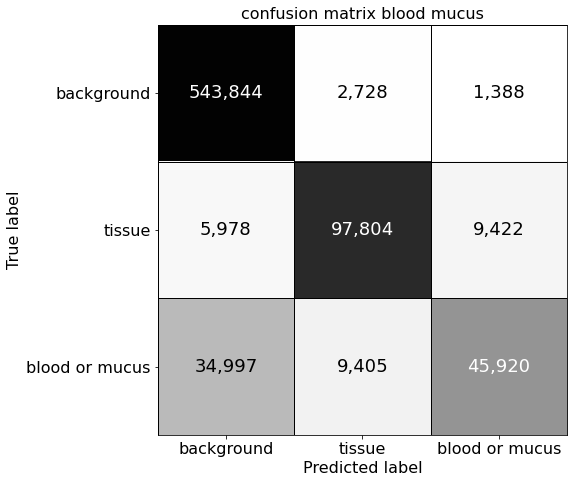

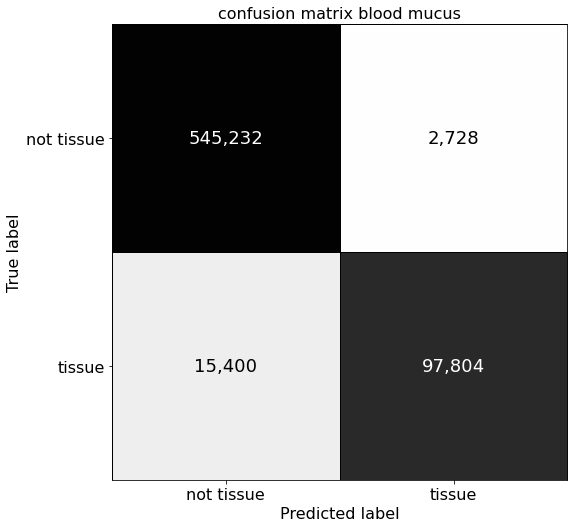

In [1]:
from repath.experiments.bloodmuc import *

predict_images()


In [ ]:
mosaic_dir = experiment_root / 'mosaic'
Image.open(mosaic_dir / "9.png")

In [ ]:
import repath.data.datasets.bloodmucus as bloodm

dset = bloodm.validation()

In [ ]:
dset.paths

In [ ]:
from repath.utils.paths import project_root

experiment_name = "bloodmucus"
experiment_root = project_root() / "experiments" / experiment_name

json_path = project_root() / dset.root / dset.paths.annotation[5]

json_path

In [ ]:
anns = dset.load_annotations(json_path, "background")
ann_areas = dset.load_annotated_area(json_path)
len(ann_areas.annotations)

In [ ]:
from PIL import Image
import numpy as np

def show_np(arr_in):
    return Image.fromarray(np.array(arr_in, dtype=np.uint8))

from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots

thumbz, annotz = get_slides_annots(dset, 6, "background")


In [ ]:
show_np(thumbz[5])

In [ ]:
show_np(anns.render(thumbz[5].shape[0:2], 64)*50)

In [ ]:
show_np(ann_areas.render(thumbz[5].shape[0:2], 64)*50)

In [ ]:
import json
from joblib import dump, load
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

import repath.data.datasets.bloodmucus as bloodm
from repath.preprocess.patching import GridPatchFinder, SlidesIndex, CombinedIndex
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots, apply_tissue_detection, get_features_list, fit_segmenter_multi, predict_segmenter, get_features, pool_blood_mucus
from repath.utils.convert import get_concat_h, get_concat_v
from repath.utils.paths import project_root
from repath.utils.seeds import set_seed

"""
Global stuff
"""
experiment_name = "bloodmucus"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123

level_label = 6
thumb_level = 7

# read in slides and annotations for training
dset = bloodm.validation()
# assume unlabeled annotations are the annotated area label as background for now
thumbz, annotz = get_slides_annots(dset, level_label, "background")
thumbz_out, annotz_out = get_slides_annots(dset, thumb_level, "background")


# apply tissue detection
morphology_transform1 = SizedClosingTransform(level_in=level_label)
morphology_transform2 = FillHolesTransform(level_in=level_label)
morphology_transforms = [morphology_transform1, morphology_transform2]
tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
filtered_thumbz = apply_tissue_detection(thumbz, tissue_detector)

# get features
featz = get_features_list(filtered_thumbz)

# set output directories
labels_dir = experiment_root / 'labels'
labels_dir.mkdir(parents=True, exist_ok=True)
tissue_dir = experiment_root / 'tissue'
tissue_dir.mkdir(parents=True, exist_ok=True)
bloodm_dir = experiment_root / 'bloodm'
bloodm_dir.mkdir(parents=True, exist_ok=True)
annot_out_dir = experiment_root / 'annot_out'
annot_out_dir.mkdir(parents=True, exist_ok=True)
mosaic_dir = experiment_root / 'mosaic'
mosaic_dir.mkdir(parents=True, exist_ok=True)

### classifier specific 
# load classifier
clf = load(experiment_root / 'rforest.joblib')
# settings for classifier
patch_level = 0
patch_size = 2**thumb_level
stride = patch_size
scale_factor = 2 ** (level_label - patch_level)
kernel_size = int(patch_size / scale_factor)
label_level_stride = int(stride / scale_factor)

In [ ]:
idx = 0
thumb = thumbz[0]

### classifier specific
features = get_features(thumb)
output = predict_segmenter(features, clf)
tissue_mask = tissue_detector(thumb)
filtered_output = np.where(np.logical_not(tissue_mask), 0, output)
output_labels = pool_blood_mucus(filtered_output, kernel_size, label_level_stride, 0)

### generic can be reused for multiple classifiers
# create image with just tissue 
thumb_out = thumbz_out[idx]
if thumb_out.shape[0:2] != output_labels.shape:
    output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]
tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, thumb_out, 255)
# create image with jsut blood mucus
bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, thumb_out, 255)
# convert to pil images and write
filename = str(idx) + '.png'
labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))
labels_image.save(labels_dir / filename)
# make annot image coloured
annot_out = annotz_out[idx]
annot_out = np.expand_dims(annot_out, axis=-1)
annot_out_cl = np.dstack((annot_out, annot_out, annot_out))
tissue = np.array([255,255,255]).reshape((1,1,3))
blood = np.array([255,0,0]).reshape((1,1,3))
mucus = np.array([255,208,182]).reshape((1,1,3))
blmuc = np.array([186,85,211]).reshape((1,1,3))
annot_out_cl = np.where(annot_out == 1, tissue, annot_out_cl)
annot_out_cl = np.where(annot_out == 2, blood, annot_out_cl)
annot_out_cl = np.where(annot_out == 3, mucus, annot_out_cl)
annot_out_cl = np.where(annot_out == 4, blmuc, annot_out_cl)

annot_out_image = Image.fromarray(np.array(annot_out_cl, dtype=np.uint8))
annot_out_image.save(annot_out_dir / filename)
tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
tissue_image.save(tissue_dir / filename)
bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
bloodm_image.save(bloodm_dir / filename)
top_row = get_concat_h(labels_image, tissue_image)
low_row = get_concat_h(bloodm_image, annot_out_image)
get_concat_v(top_row, low_row).save(mosaic_dir / filename)
print(idx)

In [ ]:
# get cut down area of annotations
annot_area = np.expand_dims(ann_areas.render(thumb_out.shape[0:2], 128), axis=-1)
print(np.max(annot_out))
annots_cut_down = np.where(annot_area > 0, annot_out, 0)
annots_cut_down_combined_bloodm = np.where(annots_cut_down > 1, 2, annots_cut_down)
show_np(annots_cut_down_combined_bloodm[:,:,0]*100)

In [ ]:
# get cut down area of predictions
preds_cut_down = np.where(np.squeeze(annot_area) > 0, output_labels, 0)
print(np.max(preds_cut_down))
show_np(preds_cut_down*100)

In [ ]:
acd_cbm = annots_cut_down_combined_bloodm[:, :, 0]
black_area_calc = preds_cut_down.shape[0]*preds_cut_down.shape[0] - np.sum(ann_areas.render(thumb_out.shape[0:2], 128)>0)
print(black_area_calc)
tru0_pred0 = np.sum(np.logical_and(acd_cbm == 0, preds_cut_down == 0))
tru0_pred1 = np.sum(np.logical_and(acd_cbm == 0, preds_cut_down == 1))
tru0_pred2 = np.sum(np.logical_and(acd_cbm == 0, preds_cut_down == 2))
tru1_pred0 = np.sum(np.logical_and(acd_cbm == 1, preds_cut_down == 0))
tru1_pred1 = np.sum(np.logical_and(acd_cbm == 1, preds_cut_down == 1))
tru1_pred2 = np.sum(np.logical_and(acd_cbm == 1, preds_cut_down == 2))
tru2_pred0 = np.sum(np.logical_and(acd_cbm == 2, preds_cut_down == 0))
tru2_pred1 = np.sum(np.logical_and(acd_cbm == 2, preds_cut_down == 1))
tru2_pred2 = np.sum(np.logical_and(acd_cbm == 2, preds_cut_down == 2))

cm = [[tru0_pred0, tru0_pred1, tru0_pred2],[tru1_pred0, tru1_pred1, tru1_pred2], [tru2_pred0, tru2_pred1, tru2_pred2]]
cm


In [ ]:
tru0_pred0 = np.sum(np.logical_and(acd_cbm == 0, np.logical_not(preds_cut_down == 1)))
tru0_pred1 = np.sum(np.logical_and(acd_cbm == 0, preds_cut_down == 1))
tru1_pred0 = np.sum(np.logical_and(acd_cbm == 1, np.logical_not(preds_cut_down == 1)))
tru1_pred1 = np.sum(np.logical_and(acd_cbm == 1, preds_cut_down == 1))
cm2 = [[tru0_pred0, tru0_pred1],[tru1_pred0, tru1_pred1]]
cm2

In [ ]:
pixvals = np.where(annot_area[:,:,0] > 0)
minrw = min(pixvals[0])
maxrw = max(pixvals[0])+1
mincl = min(pixvals[1])
maxcl = max(pixvals[1])+1
cd_annots = annot_out[minrw:maxrw, mincl:maxcl, 0]
show_np(cd_annots*50)

In [ ]:
cd_preds = output_labels[minrw:maxrw, mincl:maxcl]
show_np(cd_preds*100)

In [ ]:
cd_annots = np.where(cd_annots > 1, 2, cd_annots)
show_np(cd_annots*100)